In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot
from arch.unitroot import ADF, KPSS
from pmdarima import auto_arima
from statsmodels.stats.diagnostic import acorr_ljungbox

In [2]:
data = pd.read_csv("../data/AirPassengers.csv")

In [3]:
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
data.columns = ["Date", "Passengers"]

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [6]:
data["Date"] = pd.date_range("1949-01-01", periods = len(data), freq = "M")
data.set_index("Date", inplace = True)
data.head()

,Passengers
Date,
1949-01-31,112
1949-02-28,118
1949-03-31,132
1949-04-30,129
1949-05-31,121


In [7]:
data.isnull().sum()

Passengers    0
dtype: int64

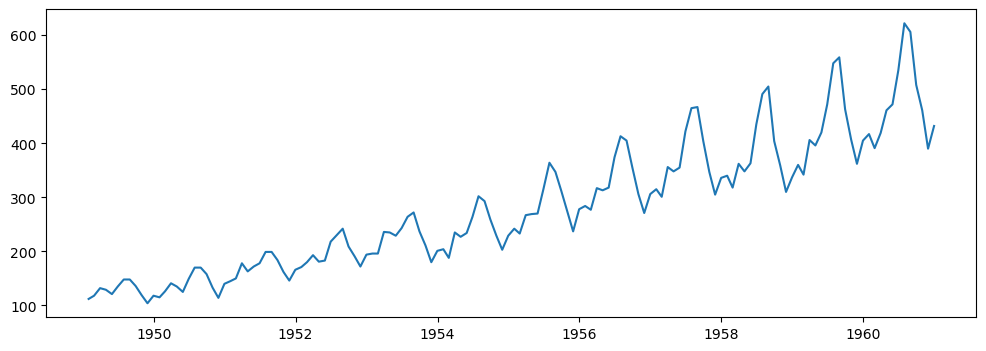

In [8]:
plt.figure(figsize = (12,4))
plt.plot(data)
plt.show();

In [9]:
# Grafiğe göre artan bir trend ve mevsimsellik görülmektedir.

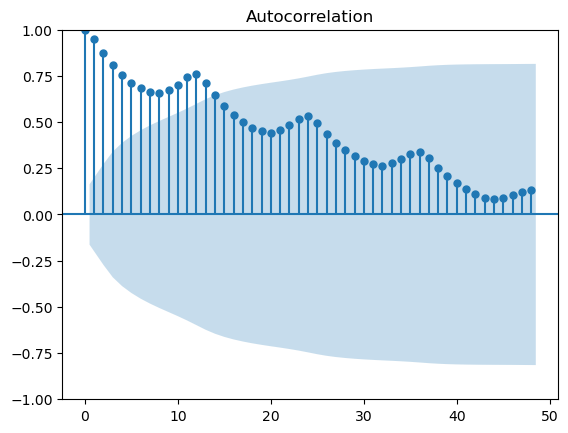

In [10]:
plot_acf(data, lags = 48)
plt.show();

In [11]:
# Otokorelasyon grafiğine göre de trend ve mevsimsellik bulunmaktadır.

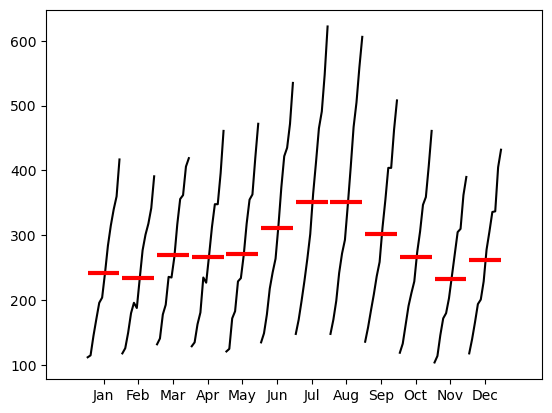

In [12]:
month_plot(data)
plt.show();

In [13]:
# Yaz aylarında ortalama yolcu sayısında artış olduğu görülmektedir.

In [14]:
train_data = data[:-24]
test_data = data[-24:] # Son 24 aylık data tahmin edilecektir.

In [15]:
# Durağanlık testleri (Grafiklere göre seri durağan değildir.)

adf = ADF(train_data)
kpss = KPSS(train_data)

print(adf)
print("\n#################################################\n")
print(kpss)

   Augmented Dickey-Fuller Results   
Test Statistic                 -0.773
P-value                         0.827
Lags                               13
-------------------------------------

Trend: Constant
Critical Values: -3.49 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

#################################################

    KPSS Stationarity Test Results   
Test Statistic                  1.706
P-value                         0.000
Lags                                6
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


In [16]:
# Her iki teste göre de seri durağan değildir.

In [17]:
# Durağanlaştırma için 1. fark alma işlemi

data_diff = train_data.diff().dropna()

adf = ADF(data_diff)
kpss = KPSS(data_diff)

print(adf)
print("\n#################################################\n")
print(kpss)

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.164
P-value                         0.220
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -3.49 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

#################################################

    KPSS Stationarity Test Results   
Test Statistic                  0.019
P-value                         0.996
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


In [18]:
# ADF testine göre süreçte hala birim kök bulunmaktadır (durağan değildir)
# KPSS testine göre ise süreç durağan hale gelmiştir.

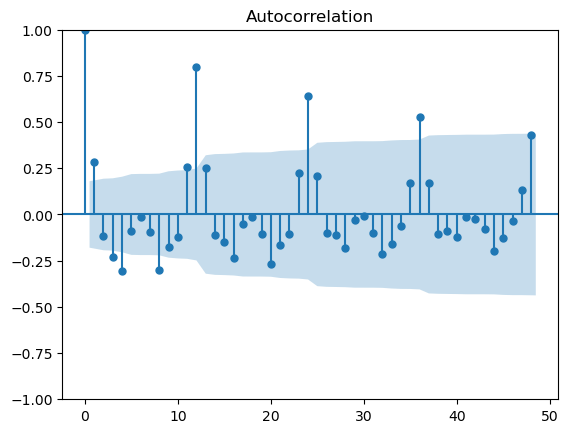

In [19]:
# Otokorelasyon grafiğine tekrar bakalım

plot_acf(data_diff, lags = 48)
plt.show();

In [20]:
# Otokorelasyon grafiğine göre, trend kaynaklı birim kök ortadan kalkmış olsa da mevsimsellik kaynaklı birim kök hala
# bulunmaktadır.
# KPSS testi trend bazlı çalıştığı için birim kök bulunmadığını söyler.

In [21]:
# Seriyi mevimsellik için de durağan hale getirmek için mevsimsel bir fark daha alabiliriz.
# Mevsimselik 12 ayda bir tekrar ettiği için mevsimsel periyod 12'dir.

   Augmented Dickey-Fuller Results   
Test Statistic                -13.052
P-value                         0.000
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.49 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

#################################################

    KPSS Stationarity Test Results   
Test Statistic                  0.109
P-value                         0.545
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


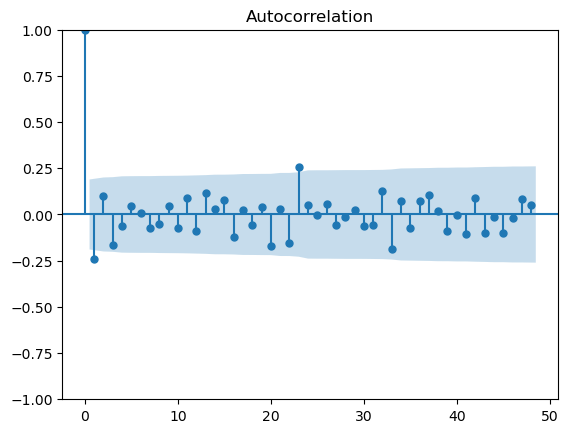

In [22]:
data_diff_seasonal = data_diff.diff(12).dropna()

adf = ADF(data_diff_seasonal)
kpss = KPSS(data_diff_seasonal)

print(adf)
print("\n#################################################\n")
print(kpss)

plot_acf(data_diff_seasonal, lags = 48)
plt.show();

In [23]:
# Her iki teste göre de süreç durağan hale gelmiştir.

In [24]:
# Model kurma

model = auto_arima(train_data, trace = True, seaosonal = True, m = 12) # m: mevsimsel periyod
print(model)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=813.749, Time=1.57 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=910.236, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=810.646, Time=0.44 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=860.575, Time=0.39 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1060.479, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=809.411, Time=0.15 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=810.721, Time=0.35 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=812.509, Time=0.96 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=808.863, Time=0.17 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=810.482, Time=0.55 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=810.553, Time=0.38 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.03 sec
 ARIMA(3,0,0)(0,1,0)[12] intercept   : AIC=809.375, Time=0.27 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=809.672, Time=0.28 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept  

In [25]:
# Model fark derecesi olan d parametresini 0 almıştır.
# d parametresini 1 alarak modeli tekrar kurarak AIC değerlerini karşılaştıralım.

model_d = auto_arima(train_data, trace = True, seaosonal = True, m = 12, d = 1) # d: durağanlık için fark derecesi
print(model_d)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=1.59 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=807.655, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=804.973, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=805.408, Time=0.19 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=803.281, Time=0.08 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=805.044, Time=0.19 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.70 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=805.093, Time=0.13 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=804.813, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=803.650, Time=0.07 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=806.793, Time=0.17 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=805.281, Time=0.13 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 3.604 seconds
 ARIMA(1,1,0)(0,1,0)[12]          


In [26]:
# model_d AIC < model AIC olduğundan model_d ile devam edilebilir.

In [27]:
# Model katsayı anlamlılıkları

model_d.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -399.641
Date:                            Thu, 22 Feb 2024   AIC                            803.281
Time:                                    11:51:25   BIC                            808.627
Sample:                                01-31-1949   HQIC                           805.448
                                     - 12-31-1958                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2397      0.091     -2.629      0.009      -0.418      -0.061
sigma2       102.6681     12.363      8.304      0.000      78.437     126.899
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.94
Prob(Q):                              0.93   Prob(JB):                         0.38
Heteroskedasticity (H):               1.42   Skew:                             0.02
Prob(H) (two-sided):                  0.30   Kurtosis:                         3.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
# P>|z| < 0.05 olduğundan istatistiksel olarak parametreler anlamlıdır.

In [29]:
# Artıkların White Noise sürecinde olması gerekmektedir. = (Artıklar arasında otokorelasyon olmamalıdır.)

print(acorr_ljungbox(model_d.resid()))

     lb_stat  lb_pvalue
1   0.000411   0.983819
2   0.617111   0.734507
3   0.983062   0.805350
4   1.283585   0.864154
5   1.675589   0.891961
6   1.726353   0.943069
7   2.459555   0.930112
8   3.138440   0.925371
9   3.387549   0.946932
10  4.800462   0.904102


In [30]:
# lb_pvalue > 0.05 olduğundan süreç White Noise.

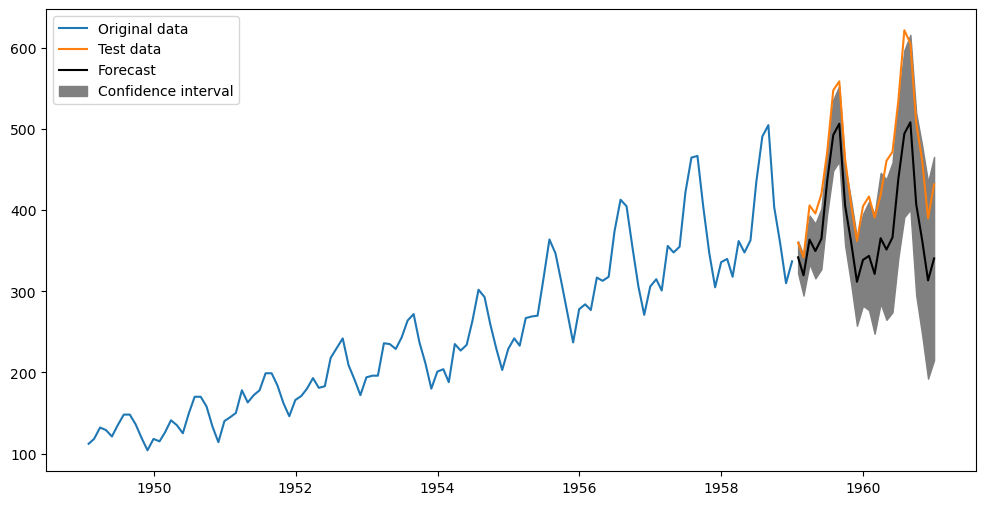

In [31]:
# Tahmin ve görselleştirme

forecast, ci = model_d.predict(24, return_conf_int = True)

plt.figure(figsize = (12,6))
plt.plot(train_data, label = "Original data")
plt.plot(test_data, label = "Test data")
plt.plot(forecast, label = "Forecast", color = "black")
plt.fill_between(forecast.index, ci[:,0], ci[:,1], color = "gray", label = "Confidence interval")
plt.legend(loc = "upper left")
plt.show();